##  Building a commit classification dataset

In [1]:
import json
import os
from collections import defaultdict

import javalang
from sklearn.model_selection import train_test_split
from unidiff import PatchSet


# List of repositories that will make up the dataset
repositories = ['apache/hadoop', 'apache/hive']

label_encoding = {
    'Bug': '001', 
    'Improvement': '010', 
    'Sub-task': '100'
}

# Filename extension for code files
code_ext = '.java'

In [14]:
def is_ascii(string): 
    return all(ord(c) < 128 for c in string)

def is_code_change(diff, code_ext):
    """
    Returns true if the diff contains changes from at least one code file
    :param diff: pull request diff
    :param code_ext: filename extension for code files
    :return: 
    """
    patch = PatchSet(diff)
    for file in patch.added_files + patch.modified_files + patch.removed_files:
        if os.path.splitext(file.path)[1] == code_ext:
            return True
    return False

In [15]:
def get_tokens(code_changes):
    """
    Returns tokens from Java code snippets.
    NOTE: This requires well formed Java code as input and doesn't work on diffs
    :param code_changes: Java code encoded as a string
    :return: tokens extracted from the input code
    """
    file_tokens = list()

    try:
        file_tokens = [''.join(x.value.split()) for x in javalang.tokenizer.tokenize('\n'.join(code_changes))
                       if len(x.value.strip()) < 64 and is_ascii(x.value)]
            
    except:
        for line in code_changes:
            try:
                line_tokens = [''.join(x.value.split()) for x in javalang.tokenizer.tokenize(line)
                               if len(x.value.strip()) < 64 and is_ascii(x.value)]
                if line_tokens and line_tokens[0] != '*':
                    file_tokens.extend(line_tokens)
            except:
                pass

    if file_tokens:
        return ' '.join(file_tokens)
    
    return None

In [2]:
def split_dataset(dataset):
    """

    :param data_x:
    :param data_y:
    :return:
    """
    dataset_labels = [x[-1] for x in dataset]
    train_split, test_split = train_test_split(dataset, stratify=dataset_labels, test_size=0.20, random_state=42)

    train_labels = [x[-1] for x in train_split]
    train_split, dev_split = train_test_split(train_split, stratify=train_labels, test_size=0.25, random_state=42)

    print("Train, dev and test split sizes:", len(train_split), len(dev_split), len(test_split))
    return train_split, dev_split, test_split

In [9]:
# List containing labelled pull requests
labelled_commits = list()

label_counts = defaultdict(int)
for repo_name in repositories:
    with open(os.path.join(os.pardir, 'data', 'commits', repo_name, 'commit_metadata.json'), 'r') as metadata_file:
        metadata_dict = json.load(metadata_file)
    with open(os.path.join(os.pardir, 'data', 'commits', repo_name, 'commit_labels.json'), 'r') as label_file:
        label_dict = json.load(label_file)
    with open(os.path.join(os.pardir, 'data', 'commits', repo_name, 'commit_diffs.json'), 'r') as diff_file:
        diff_dict = json.load(diff_file)
    
    num_processed = 0
    for commit in metadata_dict:
        diff = diff_dict[commit['sha']]
        if is_code_change(diff, code_ext):
            commit_label = label_encoding.get(label_dict.get(commit['sha'], None), None)
            if commit_label:
                labelled_commits.append((commit, repo_name, diff, commit_label))
                label_counts[commit_label] += 1
        
        num_processed += 1
        if num_processed % 1000 == 0:
            print('Processed %d of %d commits in %s' % 
                  (num_processed, len(metadata_dict), repo_name))

print("Number of labelled pull requests:", len(labelled_commits))
print("Dataset distribution:", label_counts)

NameError: name 'is_code_change' is not defined

In [10]:
# List containing all the dataset samples
dataset = list()

for commit, repo_name, diff, label in labelled_commits:
    diff_changes = list()
    patch = PatchSet(diff)
    
    for file in patch.added_files + patch.modified_files + patch.removed_files:
        if os.path.splitext(file.path)[1] == code_ext:
            file_changes = list()
            
            for hunk in file:
                for line in hunk:
                    file_changes.append(line.value)
            
            file_tokens = get_tokens(file_changes)
            if file_tokens:
                diff_changes.append(file_tokens)
    
    if diff_changes:
        dataset.append((repo_name, 
                        commit['sha'], 
                        json.dumps(diff_changes), 
                        label))

In [3]:
train_split, dev_split, test_split = split_dataset(dataset)

with open(os.path.join(os.pardir, 'data', 'commits', 'apache', 'train.tsv'), 'w') as tsv_file:
    tsv_file.write('\n'.join('\t'.join(str(y) for y in x) for x in train_split))
with open(os.path.join(os.pardir, 'data', 'commits', 'apache', 'dev.tsv'), 'w') as tsv_file:
    tsv_file.write('\n'.join('\t'.join(str(y) for y in x) for x in dev_split))
with open(os.path.join(os.pardir, 'data', 'commits', 'apache', 'test.tsv'), 'w') as tsv_file:
    tsv_file.write('\n'.join('\t'.join(str(y) for y in x) for x in test_split))

NameError: name 'dataset' is not defined

In [14]:
dataset = list()
with open(os.path.join(os.pardir, 'data', 'commits', 'apache', 'train.tsv')) as tsv_file:
    for line in tsv_file:
        line_split = line.split('\t')
        dataset.append((line_split[0], line_split[1], json.loads(line_split[2]), line_split[3].strip()))

with open(os.path.join(os.pardir, 'data', 'commits', 'apache', 'dev.tsv')) as tsv_file:
    for line in tsv_file:
        line_split = line.split('\t')
        dataset.append((line_split[0], line_split[1], json.loads(line_split[2]), line_split[3].strip()))
        
with open(os.path.join(os.pardir, 'data', 'commits', 'apache', 'test.tsv')) as tsv_file:
    for line in tsv_file:
        line_split = line.split('\t')
        dataset.append((line_split[0], line_split[1], json.loads(line_split[2]), line_split[3].strip()))
    

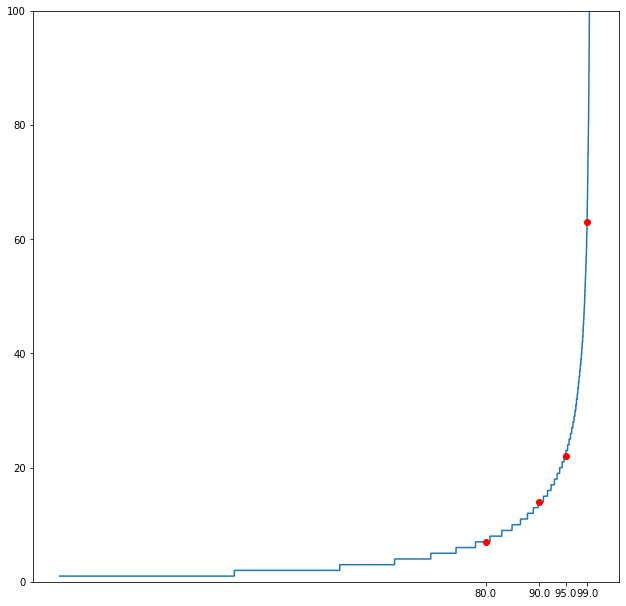

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from random import shuffle

num_files = [len(x[2]) for x in dataset]

d = np.sort(num_files)
p = np.array([80.0, 90.0, 95.0, 99.0])

perc = np.percentile(d, p)

plt.plot(d)
# Place red dots on the percentiles
plt.plot((len(d)-1) * p/100., perc, 'ro')

# Set tick locations and labels
plt.xticks((len(d)-1) * p/100., map(str, p))

# Set y-axis range
axes = plt.gca()
axes.set_ylim([0, 100])

# Set figure size
fig = plt.gcf()
fig.set_size_inches(10.5, 10.5)

plt.show()

# Filter dataset by number of files changed
# dataset = [x for x in dataset if len(x[2]) <= 22]

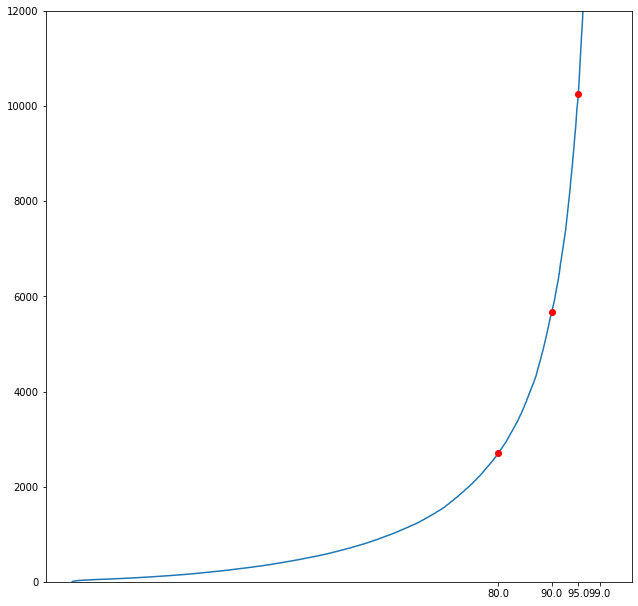

In [15]:
plt.clf()

num_lines = [sum(len(y.split()) for y in x[2]) for x in dataset]

d = np.sort(num_lines)
p = np.array([80.0, 90.0, 95.0, 99.0])

perc = np.percentile(d, p)

plt.plot(d)
# Place red dots on the percentiles
plt.plot((len(d)-1) * p/100., perc, 'ro')

# Set tick locations and labels
plt.xticks((len(d)-1) * p/100., map(str, p))

# Set y-axis range
axes = plt.gca()
axes.set_ylim([0, 12000])

# Set figure size
fig = plt.gcf()
fig.set_size_inches(10.5, 10.5)

plt.show()

# Filter dataset by number of lines changed
# dataset = [x for x in dataset if sum(len(y.split()) for y in x[2]) <= 2680]

In [7]:
label_counts = defaultdict(int)
for repo, sha, diff_changes, label in dataset:
    label_counts[label] += 1
min_count = min(label_counts.values())

shuffle(dataset)
balanced_dataset = list()
label_counts = defaultdict(int)
for repo, sha, diff_changes, label in dataset:
    if label_counts[label] < min_count:
        balanced_dataset.append((repo, sha, json.dumps(diff_changes), label))
        label_counts[label] += 1

In [8]:
train_split, dev_split, test_split = split_dataset(balanced_dataset)

with open(os.path.join(os.pardir, 'data', 'commits', 'apache', 'train_bal.tsv'), 'w') as tsv_file:
    tsv_file.write('\n'.join('\t'.join(str(y) for y in x) for x in train_split))
with open(os.path.join(os.pardir, 'data', 'commits', 'apache', 'dev_bal.tsv'), 'w') as tsv_file:
    tsv_file.write('\n'.join('\t'.join(str(y) for y in x) for x in dev_split))
with open(os.path.join(os.pardir, 'data', 'commits', 'apache', 'test_bal.tsv'), 'w') as tsv_file:
    tsv_file.write('\n'.join('\t'.join(str(y) for y in x) for x in test_split))

Train, dev and test split sizes: 13860 4620 4620
